Notebook author: Makar Shevchenko B20-DS-01

# Data Exploration and Preprocessing. Movie Recommender System. Assignment 2. Practical Machine Learning and Deep Learning

In this notebook I perform explorative data analysis of MovieLens 100k dataset [1] and preprocess the data for passing to movie recommendation model

## Solution

### Imports

In [1]:
import sys

!{sys.executable} -m pip install wget
!{sys.executable} -m pip install uszipcode

import os
from zipfile import ZipFile

import wget
import pandas as pd
import seaborn as sns
from uszipcode import SearchEngine
from matplotlib import pyplot as plt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip


/Users/19134925/.local/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Config

In [2]:
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
ZIP_SAVE_PATH = "../data/raw/ml-100k.zip"
SAVE_DIR_PATH = "../data/raw"
UNZIPPED_DIR_PATH = "../data/raw/ml-100k"
U_DATA_PATH = UNZIPPED_DIR_PATH + "/u.data"
U_INFO_PATH = UNZIPPED_DIR_PATH + "/u.info"
U_ITEM_PATH = UNZIPPED_DIR_PATH + "/u.item"
U_GENRE_PATH = UNZIPPED_DIR_PATH + "/u.genre"
U_USER_PATH = UNZIPPED_DIR_PATH + "/u.user"
U_OCCUP_PATH = UNZIPPED_DIR_PATH + "/u.occupation"
UX_BASE_PATH_F = UNZIPPED_DIR_PATH + "/u{}.base"
UX_TEST_PATH_F = UNZIPPED_DIR_PATH + "/u{}.test"
U_N_NUM = 5
USER_ID = "user_id"
ITEM_ID = "item_id"
RATING = "rating"
TS = "timestamp"
U_DATA_COL_NMS = [USER_ID, ITEM_ID, RATING, TS]
MOV_ID = "movie_id"
MOV_TITLE = "movie_title"
REL_DATE = "release_date"
VID_REL_DATE = "video_release_date"
IMDB_URL = "IMDb_URL"
GEN_UNK = "unknown"
GEN_ACT = "Action"
GEN_ADV = "Adventure"
GEN_ANIM = "Animation"
GEN_CHLD = "Children's"
GEN_CMDY = "Comedy"
GEN_CRM = "Crime"
GEN_DOC = "Documentary"
GEN_DRM = "Drama"
GEN_FNTS = "Fantasy"
GEN_NOIR = "Film-Noir"
GEN_HRR = "Horror"
GEN_MUS = "Musical"
GEN_MSTR = "Mystery"
GEN_RMNS = "Romance"
GEN_SCIFI = "Sci-Fi"
GEN_TRIL = "Thriller"
GEN_WAR = "War"
GEN_WST = "Western"
U_ITEM_COL_NMS = [MOV_ID, MOV_TITLE, REL_DATE, VID_REL_DATE, IMDB_URL, GEN_UNK,
                  GEN_ACT, GEN_ADV, GEN_ANIM, GEN_CHLD, GEN_CMDY, GEN_CRM,
                  GEN_DOC, GEN_DRM, GEN_FNTS, GEN_NOIR, GEN_HRR, GEN_MUS,
                  GEN_MSTR, GEN_RMNS, GEN_SCIFI, GEN_TRIL, GEN_WAR, GEN_WST]
AGE = "age"
GENDER = "gender"
OCCUPTN = "occupation"
ZIP_CODE = "zip_code"
U_USER_COL_NMS = [USER_ID, AGE, GENDER, OCCUPTN, ZIP_CODE]
FILES_ENC = "latin-1"
REL_YEAR = "release_year"
STATE = "state"
UNK_STATE = "unknown"
AGE_CAT = "age_cat"
BABY = "baby"
YOUNG = "young"
ADULT = "adult"
OLD = "old"
AGE_BINS = [-200, 14, 30, 50, 200]
AGE_LABELS = [BABY, YOUNG, ADULT, OLD]
PREPR_DATA_PATH = "../data/interim"
PREPR_U_DATA_PATH = PREPR_DATA_PATH + "/u_data.csv"
PREPR_U_ITEM_PATH = PREPR_DATA_PATH + "/u_item.csv"
PREPR_U_USER_PATH = PREPR_DATA_PATH + "/u_user.csv"
VIS_PATH = "../reports/figures"
U_DATA_VIS_PATH = VIS_PATH + "/u_data_vis.png"
U_ITEM_VIS_PATH = VIS_PATH + "/u_item_vis.png"
GEN_YEAR_U_ITEM_VIS_PATH = VIS_PATH + "/gen_year_u_item_vis.png"
U_USER_VIS_PATH = VIS_PATH + "/u_user_vis.png"

### Data Understanding

Here I perform explorative data analysis to find patters to exploit for better modelling

#### Data Collection

Download the dataset and read the files. Apply type convertions for time columns. Derive state column from zip code for users.

In [3]:
if not os.path.isdir(UNZIPPED_DIR_PATH):
    wget.download(DATA_URL, ZIP_SAVE_PATH)
    with ZipFile(ZIP_SAVE_PATH, "r") as zip_file:
        zip_file.extractall(SAVE_DIR_PATH)
    os.remove(ZIP_SAVE_PATH)

u_data = pd.read_csv(U_DATA_PATH, sep="\t", encoding=FILES_ENC, header=None,
                     names=U_DATA_COL_NMS)

name2num = dict()
u_info = pd.read_csv(U_INFO_PATH, sep=" ", encoding=FILES_ENC, header=None)
for i, col in u_info.iterrows():
    name2num[col[1]] = col[0]

u_item = pd.read_csv(U_ITEM_PATH, sep="|", encoding=FILES_ENC, header=None,
                     names=U_ITEM_COL_NMS)
u_item.release_date = pd.to_datetime(u_item.release_date)
u_item[REL_YEAR] = u_item[REL_DATE].dt.year

gen2idx = dict()
u_genre = pd.read_csv(U_GENRE_PATH, sep="|", encoding=FILES_ENC, header=None)
for i, col in u_genre.iterrows():
    gen2idx[col[0]] = col[1]

u_user = pd.read_csv(U_USER_PATH, sep="|", encoding=FILES_ENC, header=None,
                     names=U_USER_COL_NMS)
search = SearchEngine()
def zip_to_state(zip):
    z = search.by_zipcode(zip)
    state = z.state_abbr if z else None
    return state if state else UNK_STATE
u_user[STATE] = u_user[ZIP_CODE].apply(zip_to_state)

occups = set()
u_occup = pd.read_csv(U_OCCUP_PATH, encoding=FILES_ENC, header=None)
for i, col in u_occup.iterrows():
    occups.add(col[0])

u_n_bases = []
for i in range(1, U_N_NUM+1):
    u_n_bases.append(pd.read_csv(UX_BASE_PATH_F.format(i), sep="\t",
                                 encoding=FILES_ENC, header=None,
                                 names=U_DATA_COL_NMS))

u_n_tests = []
for i in range(1, U_N_NUM+1):
    u_n_tests.append(pd.read_csv(UX_TEST_PATH_F.format(i), sep="\t",
                                 encoding=FILES_ENC, header=None,
                                 names=U_DATA_COL_NMS))

Skip training/test sets generating scripts mku.sh and allbut.pl as the sets are already present

#### Data Description

Here I display the info about columns and samples from the data

In [4]:
print(u_data.info())
u_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [5]:
name2num

{'users': 943, 'items': 1682, 'ratings': 100000}

In [6]:
print(u_item.info())
u_item

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            1682 non-null   int64         
 1   movie_title         1682 non-null   object        
 2   release_date        1681 non-null   datetime64[ns]
 3   video_release_date  0 non-null      float64       
 4   IMDb_URL            1679 non-null   object        
 5   unknown             1682 non-null   int64         
 6   Action              1682 non-null   int64         
 7   Adventure           1682 non-null   int64         
 8   Animation           1682 non-null   int64         
 9   Children's          1682 non-null   int64         
 10  Comedy              1682 non-null   int64         
 11  Crime               1682 non-null   int64         
 12  Documentary         1682 non-null   int64         
 13  Drama               1682 non-null   int64       

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998.0
1678,1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998.0
1679,1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998.0
1680,1681,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994.0


In [7]:
gen2idx

{'unknown': 0,
 'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 "Children's": 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'Musical': 12,
 'Mystery': 13,
 'Romance': 14,
 'Sci-Fi': 15,
 'Thriller': 16,
 'War': 17,
 'Western': 18}

In [8]:
print(u_user.info())
u_user

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
 5   state       943 non-null    object
dtypes: int64(2), object(4)
memory usage: 44.3+ KB
None


,user_id,age,gender,occupation,zip_code,state
0,1,24,M,technician,85711,AZ
1,2,53,F,other,94043,CA
2,3,23,M,writer,32067,FL
3,4,24,M,technician,43537,OH
4,5,33,F,other,15213,PA
...,...,...,...,...,...,...
938,939,26,F,student,33319,FL
939,940,32,M,administrator,02215,MA
940,941,20,M,student,97229,OR
941,942,48,F,librarian,78209,TX


In [9]:
occups

{'administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer'}

In [10]:
print(f"u_n_bases number: {U_N_NUM}")
print(u_n_bases[U_N_NUM-1].info())
u_n_bases[U_N_NUM-1]

u_n_bases number: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    80000 non-null  int64
 1   item_id    80000 non-null  int64
 2   rating     80000 non-null  int64
 3   timestamp  80000 non-null  int64
dtypes: int64(4)
memory usage: 2.4 MB
None


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,4,3,876893119
3,1,5,3,889751712
4,1,6,5,887431973
...,...,...,...,...
79995,943,943,5,888639614
79996,943,1011,2,875502560
79997,943,1067,2,875501756
79998,943,1074,4,888640250


In [11]:
print(f"u_n_tests number: {U_N_NUM}")
print(u_n_tests[U_N_NUM-1].info())
u_n_tests[U_N_NUM-1]

u_n_tests number: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    20000 non-null  int64
 1   item_id    20000 non-null  int64
 2   rating     20000 non-null  int64
 3   timestamp  20000 non-null  int64
dtypes: int64(4)
memory usage: 625.1 KB
None


,user_id,item_id,rating,timestamp
0,1,3,4,878542960
1,1,13,5,875071805
2,1,15,5,875071608
3,1,18,4,887432020
4,1,19,5,875071515
...,...,...,...,...
19995,943,1028,2,875502096
19996,943,1044,3,888639903
19997,943,1047,2,875502146
19998,943,1228,3,888640275


#### Data Exploration

Here I explore statistics of the data and analyse distributions

##### U Data

In [12]:
u_data.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


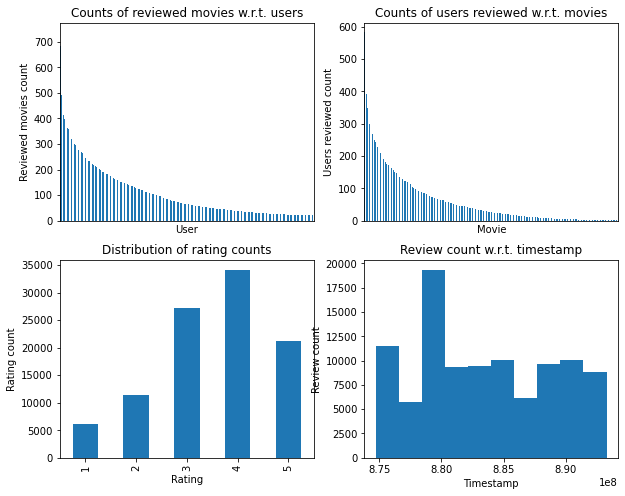

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
u_data[USER_ID].value_counts().plot(kind="bar", ax=axes[0][0])
axes[0][0].tick_params(axis="x", which="both", bottom=False, top=False,
                       labelbottom=False)
axes[0][0].title.set_text("Counts of reviewed movies w.r.t. users")
axes[0][0].set_ylabel("Reviewed movies count")
axes[0][0].set_xlabel("User")
u_data[ITEM_ID].value_counts().plot(kind="bar", ax=axes[0][1])
axes[0][1].tick_params(axis="x", which="both", bottom=False, top=False,
                       labelbottom=False)
axes[0][1].title.set_text("Counts of users reviewed w.r.t. movies")
axes[0][1].set_ylabel("Users reviewed count")
axes[0][1].set_xlabel("Movie")
u_data[RATING].value_counts().sort_index().plot(kind="bar", ax=axes[1][0])
axes[1][0].title.set_text("Distribution of rating counts")
axes[1][0].set_ylabel("Rating count")
axes[1][0].set_xlabel("Rating")
axes[1][1].hist(u_data[TS])
axes[1][1].title.set_text("Review count w.r.t. timestamp")
axes[1][1].set_ylabel("Review count")
axes[1][1].set_xlabel("Timestamp")
fig.savefig(U_DATA_VIS_PATH)

The count of reviewed movies per user vary, peaking in 550 of movies and dropping till 30.

The distribution is similar for counts of users reviewed per movie, peaking 550 users per movie and dropping till 1 review.

The most common ratings are 4, 3, and 5. 5 is given as triple more times as 1.

The time of the reviews has almost uniform distribution with some drop and peaks at 20% of periods.

##### U Item



In [14]:
u_item.describe()

,movie_id,video_release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
count,1682.000000,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,...,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1681.00000
mean,841.500000,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,...,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052,1989.38608
std,485.695893,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,...,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714,14.25358
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1922.00000
25%,421.250000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1993.00000
50%,841.500000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1995.00000
75%,1261.750000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.00000
max,1682.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1998.00000


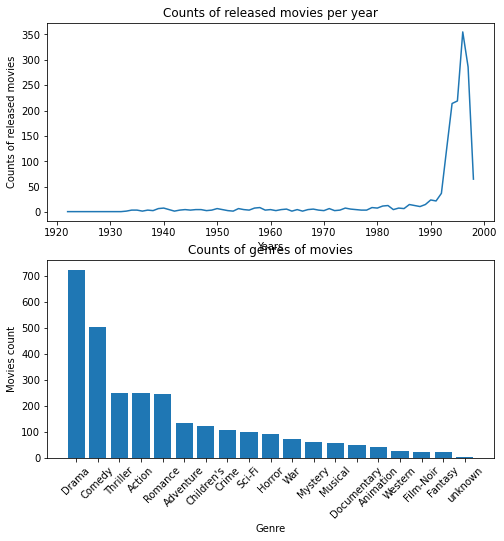

In [15]:
# reference: [2]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
rd_vc = u_item[REL_DATE].dt.year.value_counts().sort_index()
axes[0].plot(rd_vc.index, rd_vc.values)
axes[0].title.set_text("Counts of released movies per year")
axes[0].set_ylabel("Counts of released movies")
axes[0].set_xlabel("Years")
gen_vc = u_item[gen2idx.keys()].sum().sort_values(ascending=False)
axes[1].bar(gen_vc.index, gen_vc.values)
axes[1].title.set_text("Counts of genres of movies")
axes[1].set_ylabel("Movies count")
axes[1].set_xlabel("Genre")
axes[1].tick_params("x", labelrotation=45)
fig.savefig(U_ITEM_VIS_PATH)

The data is biased towards:
- movies of 1990-2000 as opposite to \<1990 and not present for \>2000
- movies of genre drama and comedy as opposite for Film-Noir and Fantasy

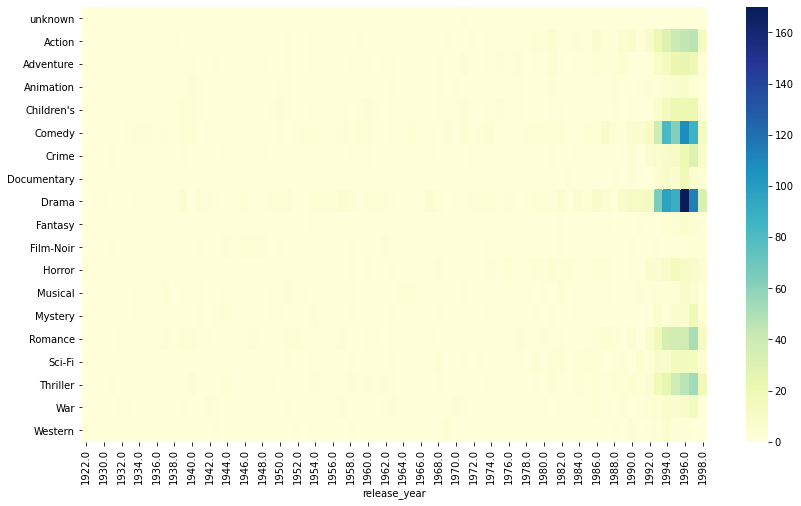

In [16]:
# reference: [3]
plt.figure(figsize=(14,8))
sns.heatmap(u_item.groupby(REL_YEAR).sum()[gen2idx.keys()].T, cmap="YlGnBu")
plt.savefig(GEN_YEAR_U_ITEM_VIS_PATH)

The distribution of movies among genres persist throughout time. The only parameter that change - number of released movies in general.

##### U User

In [17]:
u_user.describe()

,user_id,age
count,943.000000,943.000000
mean,472.000000,34.051962
std,272.364951,12.192740
min,1.000000,7.000000
25%,236.500000,25.000000
50%,472.000000,31.000000
75%,707.500000,43.000000
max,943.000000,73.000000


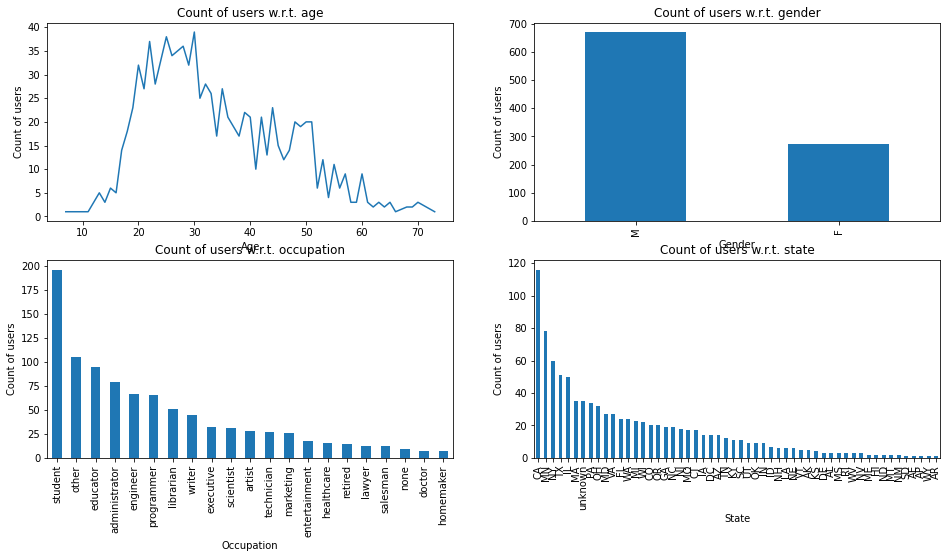

In [18]:
# reference: [2]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
age_vc = u_user[AGE].value_counts().sort_index()
axes[0][0].plot(age_vc.index, age_vc.values)
axes[0][0].title.set_text("Count of users w.r.t. age")
axes[0][0].set_ylabel("Count of users")
axes[0][0].set_xlabel("Age")
u_user[GENDER].value_counts().plot(kind="bar", ax=axes[0][1])
axes[0][1].title.set_text("Count of users w.r.t. gender")
axes[0][1].set_ylabel("Count of users")
axes[0][1].set_xlabel("Gender")
u_user[OCCUPTN].value_counts().plot(kind="bar", ax=axes[1][0])
axes[1][0].title.set_text("Count of users w.r.t. occupation")
axes[1][0].set_ylabel("Count of users")
axes[1][0].set_xlabel("Occupation")
u_user[STATE].value_counts().plot(kind="bar", ax=axes[1][1])
axes[1][1].title.set_text("Count of users w.r.t. state")
axes[1][1].set_ylabel("Count of users")
axes[1][1].set_xlabel("State")
fig.savefig(U_USER_VIS_PATH)

The data is biased towards:
- people in age of 20-30 as opposite to \<20 and \>50
- males as opposite to females;
- students as opposite to doctors
- users from CA state as opposite to AE state

#### Data Quality Verifiaction

Check for nulls and duplicate rows.

##### U Data

In [19]:
u_data.isnull().sum() * 100 / len(u_data)

user_id      0.0
item_id      0.0
rating       0.0
timestamp    0.0
dtype: float64

In [20]:
u_data[u_data.duplicated(keep=False)]

,user_id,item_id,rating,timestamp


U data has no problems with empty data

##### U Item

In [21]:
u_item.isnull().sum() * 100 / len(u_item)

movie_id                0.000000
movie_title             0.000000
release_date            0.059453
video_release_date    100.000000
IMDb_URL                0.178359
unknown                 0.000000
Action                  0.000000
Adventure               0.000000
Animation               0.000000
Children's              0.000000
Comedy                  0.000000
Crime                   0.000000
Documentary             0.000000
Drama                   0.000000
Fantasy                 0.000000
Film-Noir               0.000000
Horror                  0.000000
Musical                 0.000000
Mystery                 0.000000
Romance                 0.000000
Sci-Fi                  0.000000
Thriller                0.000000
War                     0.000000
Western                 0.000000
release_year            0.059453
dtype: float64

In [22]:
u_item[u_item.duplicated(keep=False)]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year


U Item require removal of video_release_data column with all empty cells. Release date and release_year columns require reconstructing its few empty cell or removal of the corresponding rows. IMDb_URL has missing values, however reconstruction of the data is impossible from the given data. U Item has no duplicate rows

##### U User

In [23]:
u_user.isnull().sum() * 100 / len(u_user)

user_id       0.0
age           0.0
gender        0.0
occupation    0.0
zip_code      0.0
state         0.0
dtype: float64

In [24]:
u_user[u_user.duplicated(keep=False)]

,user_id,age,gender,occupation,zip_code,state


U User has no problems with empty data

### Data Preparation

Here I select the columns needed for the model and handle missing data

#### Data Selection

##### U Data

I remove the timestamp column from U Data as matrix factorization model that I use later do not take into account time data.

In [25]:
u_data = u_data.drop(columns=[TS])

##### U Item

Among columns of U Item only genre columns seems apropriate feature for such small amount of data. I remove the rest feature columns according to the following reasoning. The release date and year columns looks noisy as the data is biased towards releases of shord time frame of 1990-1997. IMDb url is not understandable for the models. Video release date is empty. Movie titles are too abstract for the model, so it is unlikely that the meaning of the words in it relate to user rating.

In [26]:
u_item = u_item.drop(columns=[MOV_TITLE, REL_DATE, VID_REL_DATE, IMDB_URL, REL_YEAR])

##### U User

I remove the zip code column as I already derived informative data about state. The rest age, gender, occupation, and state columns I preserve as user features.

In [27]:
u_user = u_user.drop(columns=[ZIP_CODE])

#### Data Cleaning

The data that I selected has no missing or dublicated data, so no data cleaning is needed

#### Data Construction

I divide age to different groups as people of different ages has different behavior

In [28]:
u_user[AGE_CAT] = pd.cut(u_user[AGE], bins=AGE_BINS, labels=AGE_LABELS,
                         include_lowest=True)
u_user = u_user.drop(columns=[AGE])

#### Data Formatting

Here I perform one-hot encoding on gender, age group, occupation, and state columns to make the features interpretable for the model

In [29]:
u_user = pd.get_dummies(u_user, columns=[GENDER, AGE_CAT, OCCUPTN, STATE])

### Save Preprocessed Data

Save preprocessed data, item, and user tables to data/interim

In [30]:
u_data.to_csv(PREPR_U_DATA_PATH)
u_item.to_csv(PREPR_U_ITEM_PATH)
u_user.to_csv(PREPR_U_USER_PATH)

### References

```
[1] F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

[2] https://www.kaggle.com/code/amar09/eda-recommendation-model-on-movielens-100k

[3] https://www.kaggle.com/code/trishna8/movielens-100k-exploratory-data-analysis
```